In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import tensorflow as tf

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna
from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Some pre-defined valiables

BATCH_SIZE = 64
EPOCHS = 50
VERBOSE_NN = 0

In [3]:
def impute_null(df):
    
    '''
    A function to impute null values in any column of a dataframe of arbitrary data type
    '''
    
    cols = all_cols
    for col in cols:
        if (df[col].isnull().sum() > 0 and df[col].dtype == 'float64' or df[col].dtype == 'int64'):
            df[col] = df[col].fillna(value=df[col].mean())
        elif (df[col].isnull().sum() > 0 and df[col].dtype == 'object'):
            df[col] = df[col].fillna(value=df[col].mode().item())
            
    return df

def encode_feat(df, df_val=None, label_encoder=True):
    
    '''
    A function to perform categorical encoding with either of label/one-hot encoding techniques
    '''
    
    # Label Encoder
    obj_cols = categorical_cols    
    df_complete = df.append(df_val)
    
    if label_encoder == True:
        for col in obj_cols:
            le = LabelEncoder()
            df_complete[col] = le.fit_transform(df_complete[col])
    
    # One-Hot Encoder
    if label_encoder == False:
        df_complete = pd.get_dummies(df_complete)
    
    return df_complete[:df.shape[0]] if df_val is None else (df_complete[:df.shape[0]], df_complete[df.shape[0]:])

def encode_target(y, y_val=None, yield_map=False):
    
    '''
    A function to binarize output targets
    '''
    
    le = LabelEncoder()
    y_complete = y.append(y_val)
    
    y_complete = le.fit_transform(y_complete)
    classes = le.classes_
    
    if y_val is None and not yield_map:
        return y_complete[:y.shape[0]]
    elif y_val is not None and not yield_map:
        return (y_complete[:y.shape[0]], y_complete[y.shape[0]:])
    else:
        return (y_complete[:y.shape[0]], y_complete[y.shape[0]:], classes)
    
def standardize_input(df, df_val=None):
    
    '''
    A function to standardize continuous features
    '''
    
    cols=continuous_cols
    ss = StandardScaler()
    df_complete = df.append(df_val)
    
    df_complete[cols] = ss.fit_transform(df_complete[cols])
        
    return df_complete[:df.shape[0]] if df_val is None else (df_complete[:df.shape[0]], df_complete[df.shape[0]:])

def split_into_cat_and_cont(df, df_val=None):
    
    '''
    A function to split features into their categorical and continuous sets.
    '''
    
    df_complete = df.append(df_val)
    
    df_complete_cont, df_complete_cat = df_complete[continuous_cols], df_complete[categorical_cols]
    
    return (df_complete_cat[:df.shape[0]], df_complete_cont[:df.shape[0]]) if df_val is None else (df_complete_cat[:df.shape[0]], df_complete_cont[:df.shape[0]], df_complete_cat[df.shape[0]:], df_complete_cont[df.shape[0]:])

In [4]:
# Read the dataset
dataset = pd.read_csv('../input/invistico-airline/Invistico_Airline.csv')
dataset.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [5]:
# Hard-code column names of each datatype for convenience

all_cols = dataset.columns

categorical_cols = [
    'Gender', 
    'Customer Type',
    'Type of Travel', 
    'Class',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Cleanliness',
    'Online support'
]

continuous_cols = [
    'Flight Distance',
    'Total Delay in Minutes',
    'Age',
]

In [6]:
dataset.isnull().sum() 

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

In [7]:
dataset = impute_null(dataset) # Impute null values
dataset.isnull().sum()

satisfaction                         0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

In [8]:
feats = dataset.drop(columns=['satisfaction'])
labels = dataset['satisfaction']

# An unseen test set for final evaluation was sampled
X, X_test, y, y_test = train_test_split(feats, labels, test_size=0.2, shuffle=True, random_state=42) 

# A new feature called 'Total Delay in Minutes' was created as follows to ensure least correlation among features
X['Total Delay in Minutes'] = X['Arrival Delay in Minutes'].values + X['Departure Delay in Minutes'].values
X_test['Total Delay in Minutes'] = X_test['Arrival Delay in Minutes'].values + X_test['Departure Delay in Minutes'].values
X = X.drop(columns=['Arrival Delay in Minutes', 'Departure Delay in Minutes'])
X_test = X_test.drop(columns=['Arrival Delay in Minutes', 'Departure Delay in Minutes'])

In [9]:
# multi-input NN architecture

def NN():
    input1 = tf.keras.layers.Input(shape=(len(categorical_cols),), name='categorical')
    
    cat_layer1 = tf.keras.layers.Dense(128)(input1)
    cat_layer2 = tf.keras.layers.BatchNormalization()(cat_layer1) # Why this ordering?
    cat_layer3 = tf.keras.layers.PReLU()(cat_layer2) # What is this?
    cat_layer4 = tf.keras.layers.Dropout(0.3)(cat_layer3)
    
    cat_layer5 = tf.keras.layers.Dense(64)(cat_layer4)
    cat_layer6 = tf.keras.layers.BatchNormalization()(cat_layer5) # Why this ordering?
    cat_layer7 = tf.keras.layers.PReLU()(cat_layer6) # What is this?
    cat_layer8 = tf.keras.layers.Dropout(0.3)(cat_layer7)
    
    input2 = tf.keras.layers.Input(shape=(len(continuous_cols),), name='continuous')
    
    cont_layer1 = tf.keras.layers.Dense(128)(input2)
    cont_layer2 = tf.keras.layers.BatchNormalization()(cont_layer1) # Why this ordering?
    cont_layer3 = tf.keras.layers.PReLU()(cont_layer2) # What is this?
    cont_layer4 = tf.keras.layers.Dropout(0.3)(cont_layer3)
    
    cont_layer5 = tf.keras.layers.Dense(64)(cont_layer4)
    cont_layer6 = tf.keras.layers.BatchNormalization()(cont_layer5) # Why this ordering?
    cont_layer7 = tf.keras.layers.PReLU()(cont_layer6) # What is this?
    cont_layer8 = tf.keras.layers.Dropout(0.3)(cont_layer7)
    
    combined_layer = tf.keras.layers.concatenate([cat_layer8, cont_layer8])
    x = tf.keras.layers.Dense(64, activation='relu')(combined_layer)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=(input1, input2), outputs=out)
    
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001)
    optimizer = tf.keras.optimizers.Adam()
    metrics = [tf.keras.metrics.AUC()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

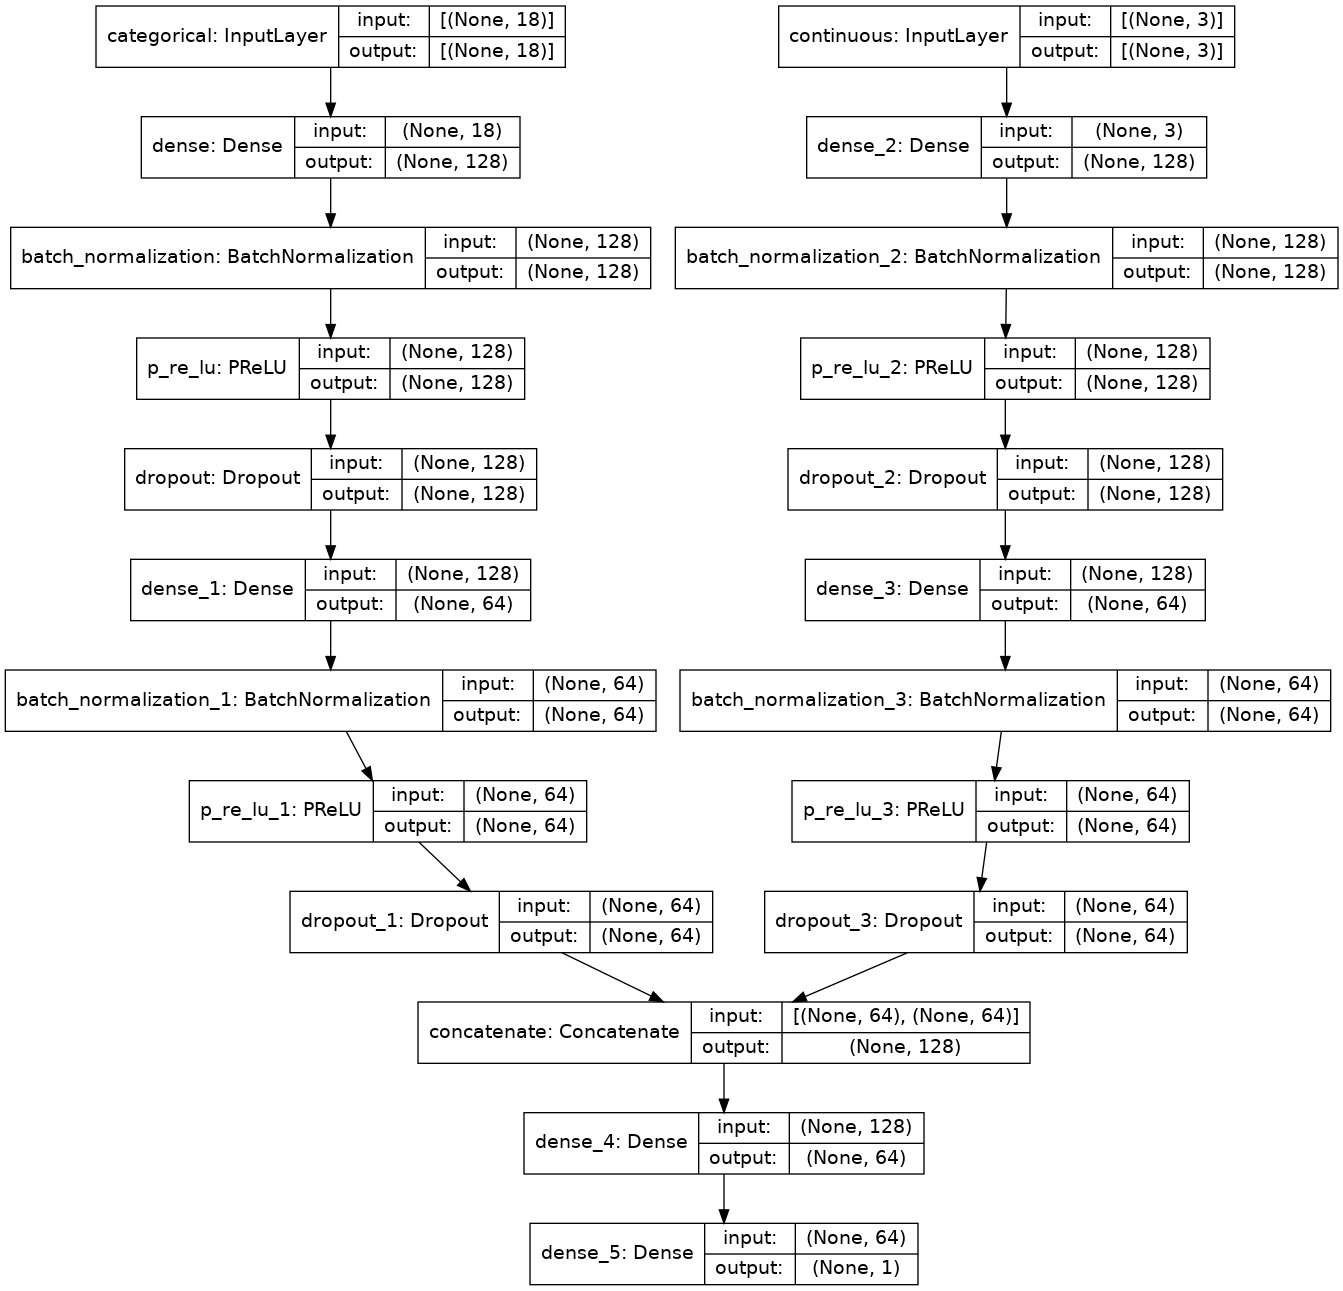

In [10]:
model = NN()
tf.keras.utils.plot_model(model, 'NN.png', show_shapes=True)

In [11]:
# Model hyper-parameters
xgb_params = {
    'random_state': 42,
    'objective': 'reg:logistic', 
    'tree_method': 'hist',
    'verbosity': 0
}

lgbm_params = {
    'random_state': 42,
    'objective': 'binary',
    'verbose': -1
}

cb_params = {
    'random_state': 42,
    'objective': 'CrossEntropy',
}

In [12]:
# NN schedulers
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
rop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', patience=5, mode='max', min_lr=1e-4)

Fold: 0 - auc_roc
XGBoost: 0.9941726452364095
LGBM: 0.9947911186128092
CatBoost: 0.9945298467105799
NN: 0.9944853904036455 

Feature Importance
XGBoost


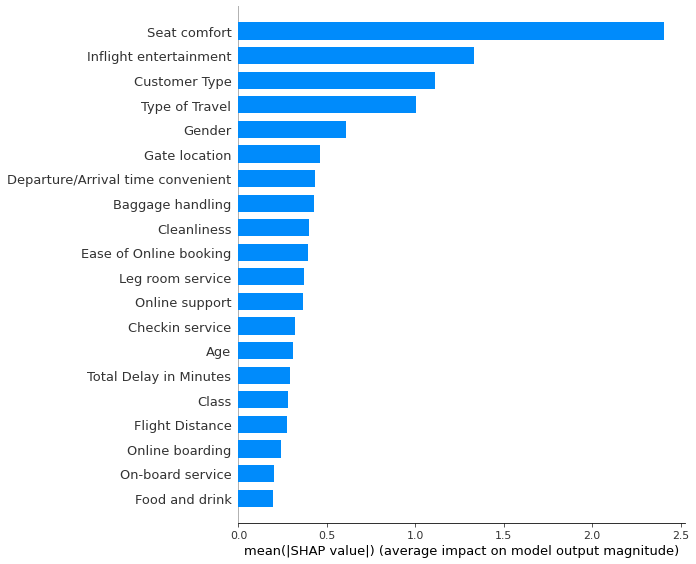

LGBM


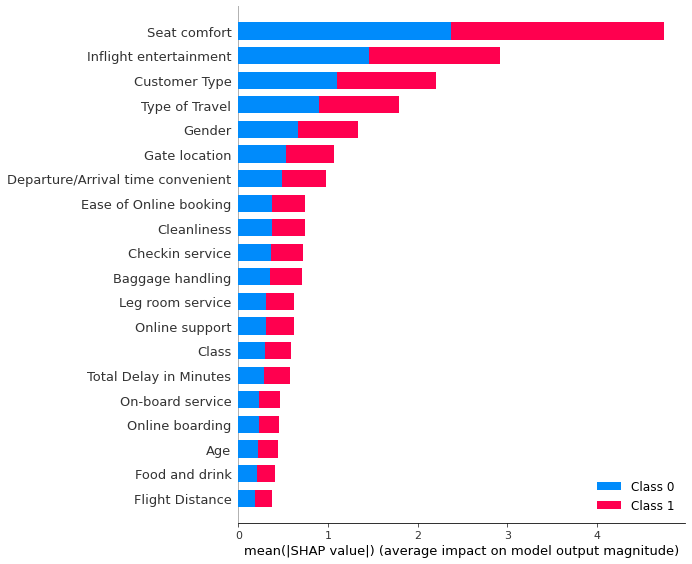

CatBoost


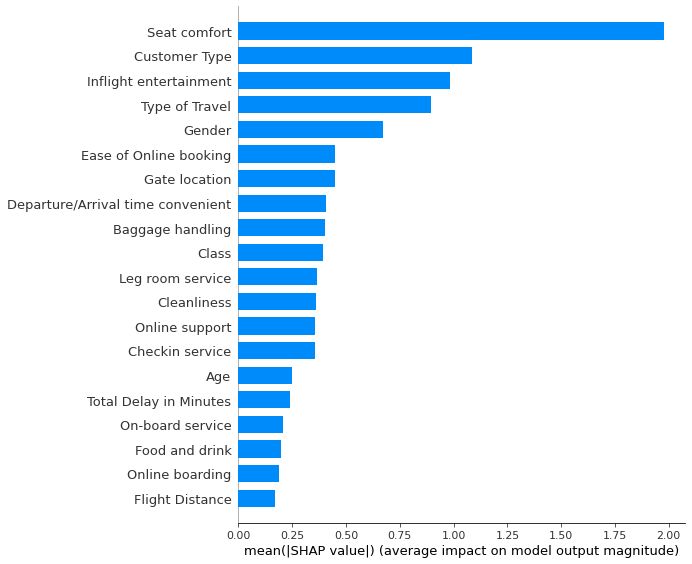

Fold: 1 - auc_roc
XGBoost: 0.9935624357086339
LGBM: 0.9943530391867696
CatBoost: 0.9942578775002904
NN: 0.9945753167048199 

Feature Importance
XGBoost


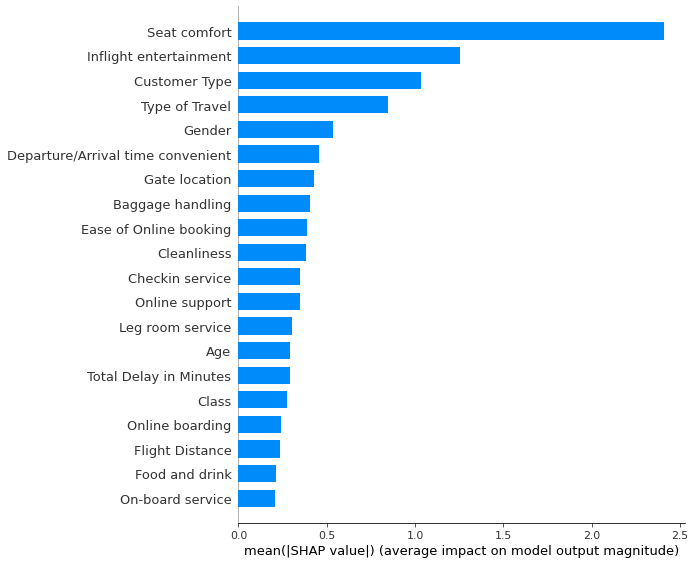

LGBM


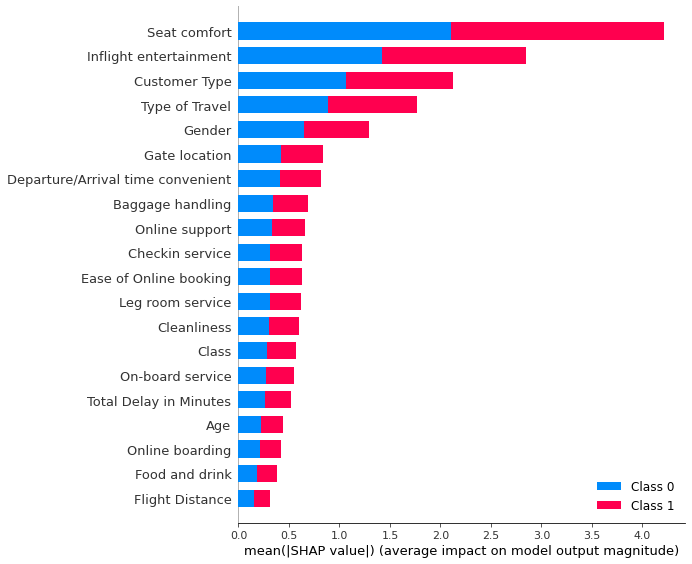

CatBoost


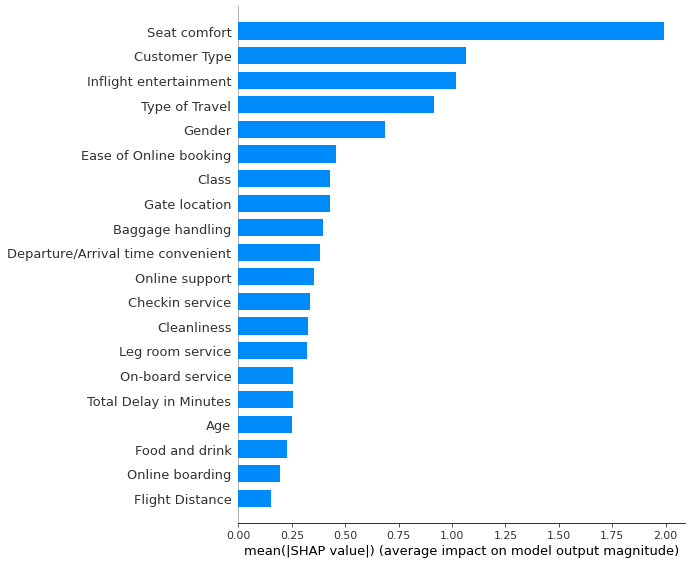

Fold: 2 - auc_roc
XGBoost: 0.9940521002805536
LGBM: 0.9944516765872764
CatBoost: 0.9946864928371141
NN: 0.9943880485966112 

Feature Importance
XGBoost


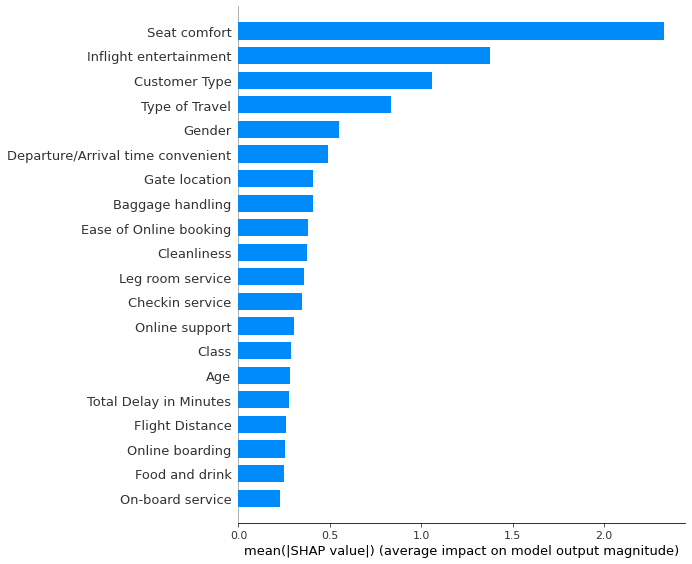

LGBM


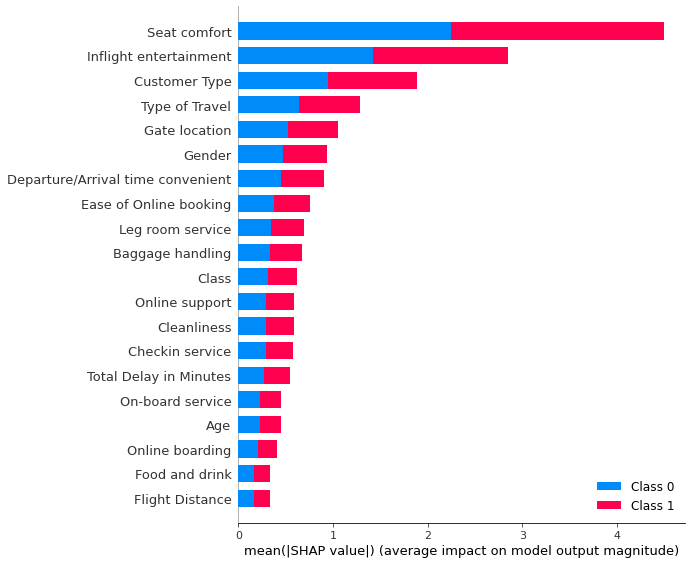

CatBoost


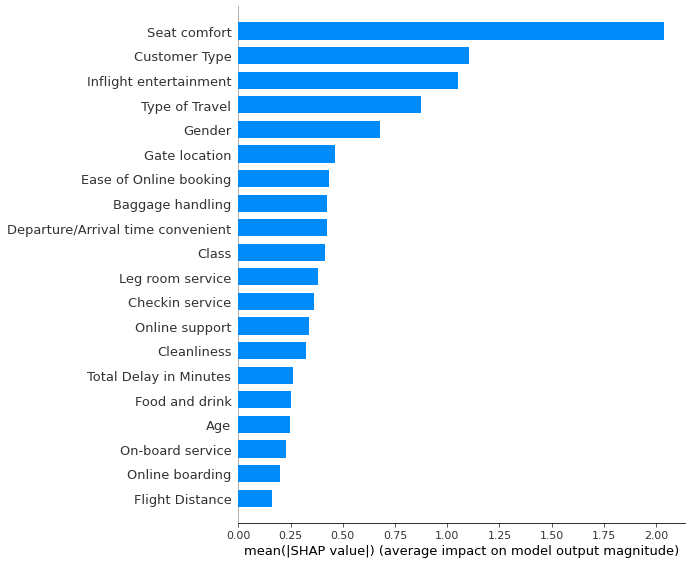

Fold: 3 - auc_roc
XGBoost: 0.9936790963681703
LGBM: 0.9941413850204649
CatBoost: 0.9939817731314001
NN: 0.9945581717176141 

Feature Importance
XGBoost


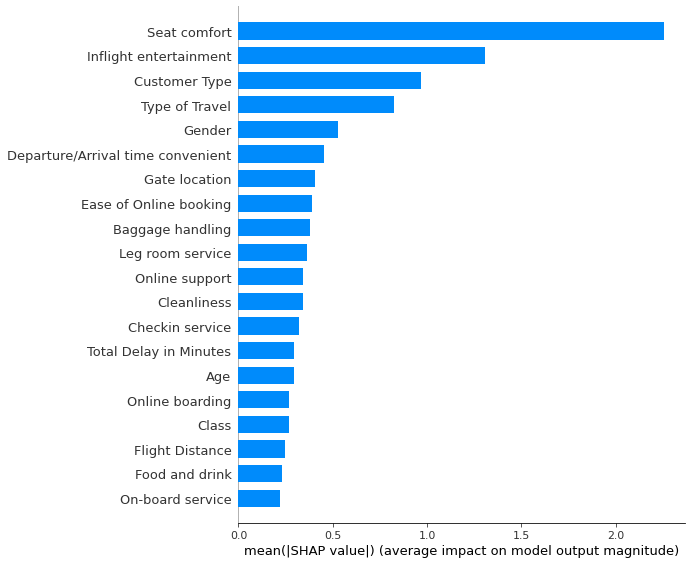

LGBM


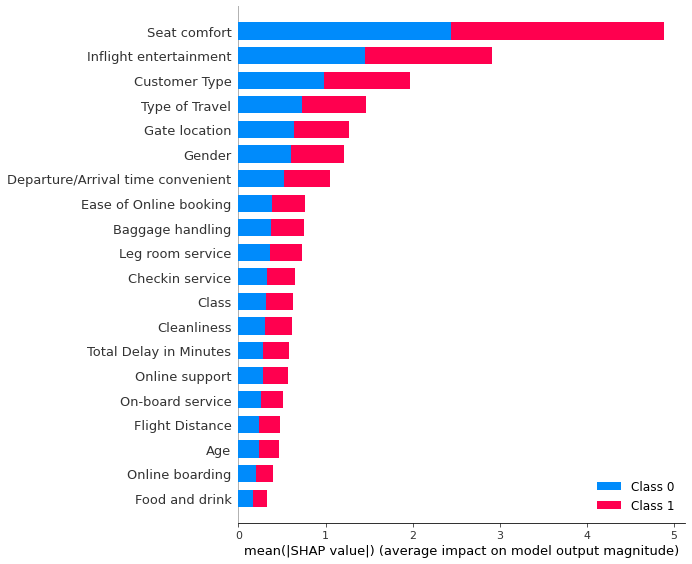

CatBoost


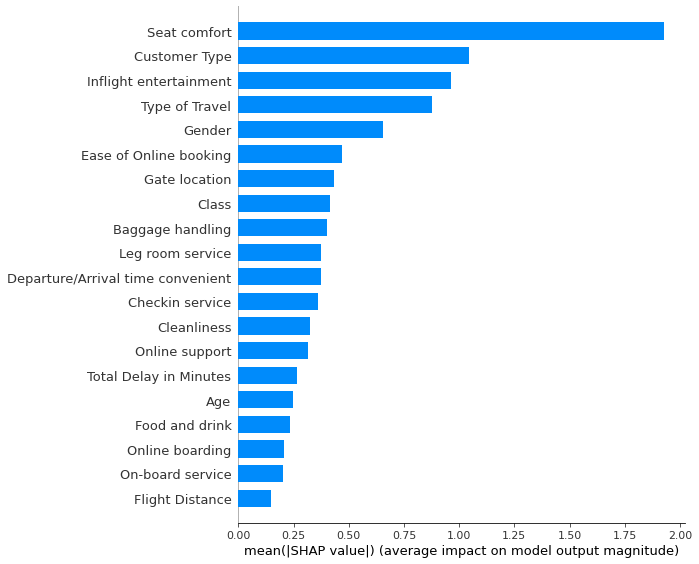

Fold: 4 - auc_roc
XGBoost: 0.9941298678207336
LGBM: 0.9944844095860611
CatBoost: 0.9946621383398568
NN: 0.9948374142125873 

Feature Importance
XGBoost


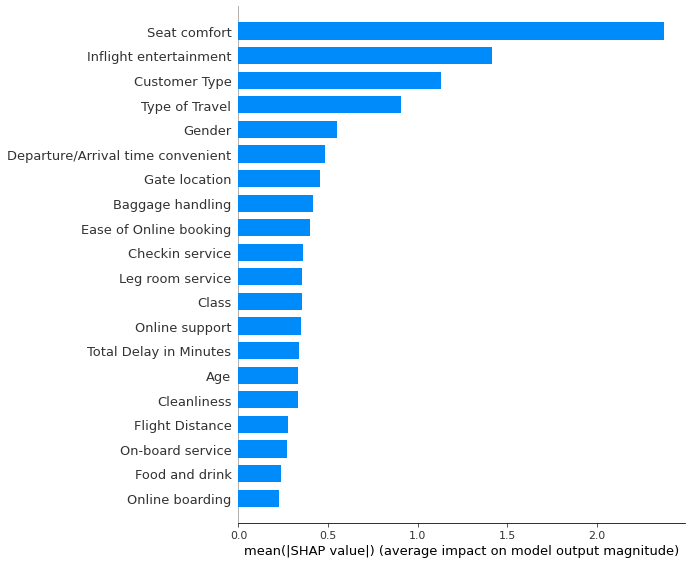

LGBM


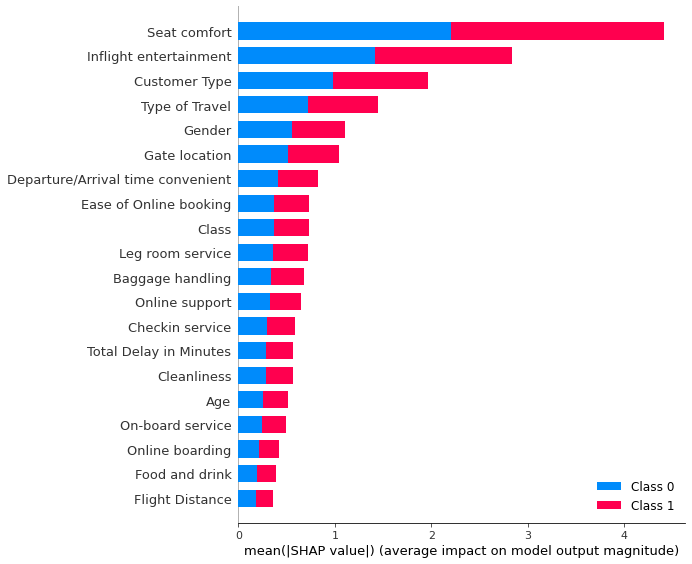

CatBoost


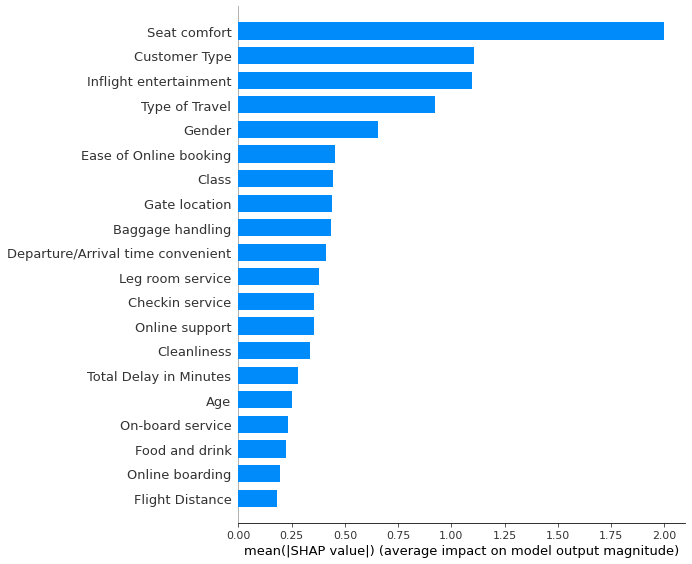

Overall auc_roc
XGBoost: 0.9939168680078211
LGBM: 0.9944397640487987
CatBoost: 0.9944252553854027
NN: 0.9945609980962973


In [13]:
# Training and Validation Loop
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {}
models['XGBoost'], models['LGBM'], models['CatBoost'], models['NN'] = [], [], [], []
valid_preds = pd.DataFrame({'True': y, 'XGBoost': np.zeros(len(y)), 'LGBM': np.zeros(len(y)), 'CatBoost': np.zeros(len(y)), 'NN': np.zeros(len(y))})

for idx, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    
    X_train, X_valid = standardize_input(*encode_feat(X.iloc[train_idx], X.iloc[valid_idx]))
    y_train, y_valid = encode_target(y.iloc[train_idx], y.iloc[valid_idx])
    
    X_cat_train, X_cont_train, X_cat_valid, X_cont_valid = split_into_cat_and_cont(X_train, X_valid)
    
    X_train, X_valid = X_train.values, X_valid.values
    X_cat_train, X_cont_train, X_cat_valid, X_cont_valid = X_cat_train.values, X_cont_train.values, X_cat_valid.values, X_cont_valid.values
        
    DTrain = xgb.DMatrix(data=X_train, label=y_train)
    DValid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    LGBMTrain = lgb.Dataset(data=X_train, label=y_train)
    LGBMValid = lgb.Dataset(data=X_valid, label=y_valid)
    
    CBTrain = cb.Pool(data=X_train, label=y_train)
    CBValid = cb.Pool(data=X_valid, label=y_valid)
    
    xgboost = xgb.train(xgb_params, DTrain, verbose_eval=False, evals=[(DValid, 'valid')], num_boost_round=15000, early_stopping_rounds=50)
    lgbm = lgb.train(lgbm_params, LGBMTrain, valid_sets=[LGBMValid], verbose_eval=False, num_boost_round=15000, early_stopping_rounds=50)
    catboost = cb.train(params=cb_params, pool=CBTrain, verbose=False, evals=(CBValid), num_boost_round=15000, early_stopping_rounds=50)
    nn = NN()
    nn.fit(
        (X_cat_train, X_cont_train),
        y_train,
        validation_data=((X_cat_valid, X_cont_valid), y_valid),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es, rop],
        verbose=VERBOSE_NN
    )
    
    joblib.dump(xgboost, f'XGBoost_{idx}' + '.h5') 
    joblib.dump(lgbm, f'LGBM_{idx}' + '.h5')
    joblib.dump(catboost, f'CatBoost_{idx}' + '.h5')
    nn.save('NN.h5')

    models['XGBoost'].append(xgboost)
    models['LGBM'].append(lgbm)
    models['CatBoost'].append(catboost)
    models['NN'].append(nn)
    
    y_pred_xgboost = xgboost.predict(DValid)
    y_pred_lgbm = lgbm.predict(X_valid)
    y_pred_catboost = catboost.predict(X_valid)
    y_pred_nn = nn.predict((X_cat_valid, X_cont_valid))
    
    valid_preds['XGBoost'].iloc[valid_idx] = y_pred_xgboost
    valid_preds['LGBM'].iloc[valid_idx] = y_pred_lgbm
    valid_preds['CatBoost'].iloc[valid_idx] = y_pred_catboost
    valid_preds['NN'].iloc[valid_idx] = y_pred_nn.reshape(-1,)
    
    print(f'Fold: {idx} - auc_roc')
    print(f'XGBoost: {metrics.roc_auc_score(y_valid, y_pred_xgboost)}')
    print(f'LGBM: {metrics.roc_auc_score(y_valid, y_pred_lgbm)}')
    print(f'CatBoost: {metrics.roc_auc_score(y_valid, y_pred_catboost)}')
    print(f'NN: {metrics.roc_auc_score(y_valid, y_pred_nn)}', '\n')
    
    print(f'Feature Importance')
    print('XGBoost')
    explainer_values = shap.TreeExplainer(xgboost).shap_values(X_valid)
    shap.summary_plot(explainer_values, pd.DataFrame(X_valid, columns=X.columns), plot_type="bar") # , plot_type="bar")
    
    print('LGBM')
    explainer_values = shap.TreeExplainer(lgbm).shap_values(X_valid)
    shap.summary_plot(explainer_values, pd.DataFrame(X_valid, columns=X.columns), plot_type="bar") # , plot_type="bar")
    
    print('CatBoost')
    explainer_values = shap.TreeExplainer(catboost).shap_values(X_valid)
    shap.summary_plot(explainer_values, pd.DataFrame(X_valid, columns=X.columns), plot_type="bar") # , plot_type="bar")

print('Overall auc_roc')
print('XGBoost:', metrics.roc_auc_score(valid_preds['True'], valid_preds['XGBoost']))
print('LGBM:', metrics.roc_auc_score(valid_preds['True'], valid_preds['LGBM']))
print('CatBoost:', metrics.roc_auc_score(valid_preds['True'], valid_preds['CatBoost']))
print('NN:', metrics.roc_auc_score(valid_preds['True'], valid_preds['NN']))

In [14]:
# Ensemble loop
lr_models = []
ensemble_preds = pd.DataFrame({'True': y, 'Ensemble_pred': np.zeros(len(y))})

oofs = valid_preds.drop(columns='True').values

for idx, (train_idx, valid_idx) in enumerate(skf.split(oofs, y)):
    
    oof_train, oof_valid = oofs[train_idx], oofs[valid_idx]
    y_train, y_valid = encode_target(y.iloc[train_idx], y.iloc[valid_idx])
    
    lr = LogisticRegression(random_state=42)
    lr.fit(oof_train, y_train)
    
    lr_models.append(lr)
    
    joblib.dump(lr, f'Ensemble_{idx}' + '.h5') 
    
    y_pred = lr.predict_proba(oof_valid)[:,1]
    
    ensemble_preds['Ensemble_pred'].iloc[valid_idx] = y_pred
    
    print(f'Fold: {idx} - auc_roc')
    print('Ensemble:', metrics.roc_auc_score(y_valid, y_pred))
    
print('Overall auc_roc')
print('Ensemble:', metrics.roc_auc_score(ensemble_preds['True'], ensemble_preds['Ensemble_pred']))

Fold: 0 - auc_roc
Ensemble: 0.9948344443579237
Fold: 1 - auc_roc
Ensemble: 0.9947121308997255
Fold: 2 - auc_roc
Ensemble: 0.9949838439094952
Fold: 3 - auc_roc
Ensemble: 0.9945420918685783
Fold: 4 - auc_roc
Ensemble: 0.9950878650497909
Overall auc_roc
Ensemble: 0.9948306731119695


Text(0.5, 1.0, 'Validation Overall AUC-ROC curves')

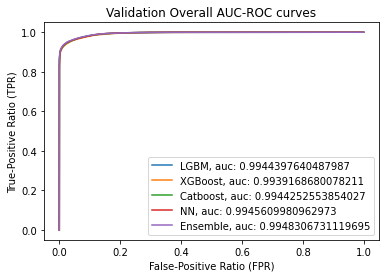

In [15]:
# Validation Results
xgboost_auc = metrics.roc_auc_score(valid_preds['True'], valid_preds['XGBoost'])
lgbm_auc = metrics.roc_auc_score(valid_preds['True'], valid_preds['LGBM'])
catboost_auc = metrics.roc_auc_score(valid_preds['True'], valid_preds['CatBoost'])
nn_auc = metrics.roc_auc_score(valid_preds['True'], valid_preds['NN'])
ensemble_auc = metrics.roc_auc_score(ensemble_preds['True'], ensemble_preds['Ensemble_pred'])

fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(encode_target(valid_preds['True']), valid_preds['XGBoost'])
fpr_lgbm, tpr_lgbm, _ = metrics.roc_curve(encode_target(valid_preds['True']), valid_preds['LGBM'])
fpr_catboost, tpr_catboost, _ = metrics.roc_curve(encode_target(valid_preds['True']), valid_preds['CatBoost'])
fpr_nn, tpr_nn, _ = metrics.roc_curve(encode_target(valid_preds['True']), valid_preds['NN'])
fpr_ensemble, tpr_ensemble, _ = metrics.roc_curve(encode_target(ensemble_preds['True']),  ensemble_preds['Ensemble_pred'])

plt.plot(fpr_lgbm, tpr_lgbm, label=f'LGBM, auc: {lgbm_auc}')
plt.plot(fpr_xgboost, tpr_xgboost, label=f'XGBoost, auc: {xgboost_auc}')
plt.plot(fpr_catboost, tpr_catboost, label=f'Catboost, auc: {catboost_auc}')
plt.plot(fpr_nn, tpr_nn, label=f'NN, auc: {nn_auc}')
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble, auc: {ensemble_auc}')

plt.legend()
plt.xlabel('False-Positive Ratio (FPR)')
plt.ylabel('True-Positive Ratio (TPR)')
plt.title('Validation Overall AUC-ROC curves')

In [16]:
# Testing
X_test = standardize_input(encode_feat(X_test))
y_test = encode_target(y_test)

X_cat_test, X_cont_test = split_into_cat_and_cont(X_test)

X_test = X_test.values
X_cat_test, X_cont_test = X_cat_test.values, X_cont_test.values

DTest = xgb.DMatrix(data=X_test, label=y_test)
CBTest = cb.Pool(data=X_test, label=y_test)

y_test_xgboost = np.mean(
    [
        models['XGBoost'][0].predict(DTest),
        models['XGBoost'][1].predict(DTest),
        models['XGBoost'][2].predict(DTest),
        models['XGBoost'][3].predict(DTest),
        models['XGBoost'][4].predict(DTest),
    ], axis=0
    
)

y_test_lgbm = np.mean(
    [
        models['LGBM'][0].predict(X_test),
        models['LGBM'][1].predict(X_test),
        models['LGBM'][2].predict(X_test),
        models['LGBM'][3].predict(X_test),
        models['LGBM'][4].predict(X_test)
    ], axis=0
    
)

y_test_catboost = np.mean(
    [
        models['CatBoost'][0].predict(CBTest),
        models['CatBoost'][1].predict(CBTest),
        models['CatBoost'][2].predict(CBTest),
        models['CatBoost'][3].predict(CBTest),
        models['CatBoost'][4].predict(CBTest)
    ], axis=0
    
)

y_test_nn = np.mean(
    [
        models['NN'][0].predict((X_cat_test, X_cont_test)).reshape(-1,),
        models['NN'][1].predict((X_cat_test, X_cont_test)).reshape(-1,),
        models['NN'][2].predict((X_cat_test, X_cont_test)).reshape(-1,),
        models['NN'][3].predict((X_cat_test, X_cont_test)).reshape(-1,),
        models['NN'][4].predict((X_cat_test, X_cont_test)).reshape(-1,)
    ], axis=0
    
)

test_preds = pd.DataFrame({'True': y_test, 'XGBoost': y_test_xgboost, 'LGBM': y_test_lgbm, 'CatBoost': y_test_catboost, 'NN': y_test_nn.reshape(-1,)})

lr_preds = np.mean(
    [
        lr_models[0].predict_proba(test_preds.drop(columns='True').values)[:,1],
        lr_models[1].predict_proba(test_preds.drop(columns='True').values)[:,1],
        lr_models[2].predict_proba(test_preds.drop(columns='True').values)[:,1],
        lr_models[3].predict_proba(test_preds.drop(columns='True').values)[:,1],
        lr_models[4].predict_proba(test_preds.drop(columns='True').values)[:,1]
    ], axis=0
)

Text(0.5, 1.0, 'Test Overall AUC-ROC curves')

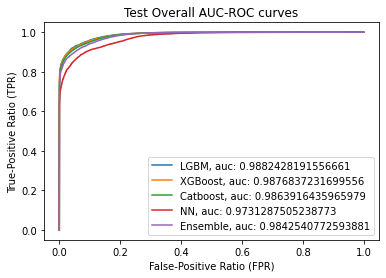

In [17]:
# Test Results
xgboost_auc = metrics.roc_auc_score(test_preds['True'], test_preds['XGBoost'])
lgbm_auc = metrics.roc_auc_score(test_preds['True'], test_preds['LGBM'])
catboost_auc = metrics.roc_auc_score(test_preds['True'], test_preds['CatBoost'])
nn_auc = metrics.roc_auc_score(test_preds['True'], test_preds['NN'])
ensemble_auc = metrics.roc_auc_score(y_test, lr_preds)

fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(test_preds['True'], test_preds['XGBoost'])
fpr_lgbm, tpr_lgbm, _ = metrics.roc_curve(test_preds['True'], test_preds['LGBM'])
fpr_catboost, tpr_catboost, _ = metrics.roc_curve(test_preds['True'], test_preds['CatBoost'])
fpr_nn, tpr_nn, _ = metrics.roc_curve(test_preds['True'], test_preds['NN'])
fpr_ensemble, tpr_ensemble, _ = metrics.roc_curve(y_test,  lr_preds)

plt.plot(fpr_lgbm, tpr_lgbm, label=f'LGBM, auc: {lgbm_auc}')
plt.plot(fpr_xgboost, tpr_xgboost, label=f'XGBoost, auc: {xgboost_auc}')
plt.plot(fpr_catboost, tpr_catboost, label=f'Catboost, auc: {catboost_auc}')
plt.plot(fpr_nn, tpr_nn, label=f'NN, auc: {nn_auc}')
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble, auc: {ensemble_auc}')

plt.legend()
plt.xlabel('False-Positive Ratio (FPR)')
plt.ylabel('True-Positive Ratio (TPR)')
plt.title('Test Overall AUC-ROC curves')